In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Load data
data = pd.read_csv(r"C:\Users\POOJITHA\Downloads\archive (3)\NFLX.csv")
data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


In [3]:
close_data = data['Close'].values.reshape(-1, 1)

close_data

array([[254.259995],
       [265.720001],
       [264.559998],
       ...,
       [429.480011],
       [405.600006],
       [410.170013]])

In [4]:
# Normalize data using StandardScaler
scaler = StandardScaler()
scaled_price = scaler.fit_transform(close_data)


In [5]:
seq_length = 15

# Prepare input and target data
x, y = [], []
for i in range(len(scaled_price) - seq_length):
    x.append(scaled_price[i:i+seq_length])
    y.append(scaled_price[i+seq_length])
x = np.array(x)
y = np.array(y)

In [6]:
# Convert to PyTorch tensors and create DataLoader
train_size = int(0.8 * len(x))
train_x = torch.tensor(x[:train_size]).float()
train_y = torch.tensor(y[:train_size]).float()
test_x = torch.tensor(x[train_size:]).float()
test_y = torch.tensor(y[train_size:]).float()


In [7]:
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [8]:
# Define a more complex LSTM model with dropout
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        return self.fc(output[:, -1, :])

model = Model(input_size=1, hidden_size=64, num_layers=2, dropout_prob=0.2)

# Use a different optimizer and a learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
loss_fn = nn.MSELoss()

In [9]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0337
Epoch [20/100], Loss: 0.0110
Epoch [30/100], Loss: 0.0266
Epoch [40/100], Loss: 0.0403
Epoch [50/100], Loss: 0.0174
Epoch [60/100], Loss: 0.0177
Epoch [70/100], Loss: 0.0068
Epoch [80/100], Loss: 0.0081
Epoch [90/100], Loss: 0.0111
Epoch [100/100], Loss: 0.0111


In [10]:

# Evaluation
model.eval()
with torch.no_grad():
    test_output = model(test_x)
    
# Inverse transform predictions and true values
predicted_prices = scaler.inverse_transform(test_output.numpy())
true_prices = scaler.inverse_transform(test_y.numpy())


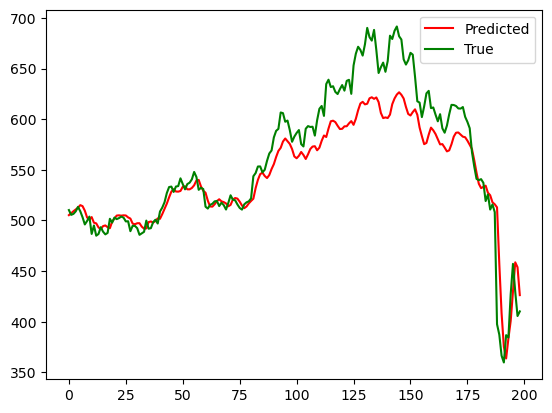

In [11]:

# Plot the results
plt.plot(predicted_prices, color='red', label='Predicted')
plt.plot(true_prices, color='green', label='True')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(true_prices, predicted_prices)
print(f'Mean Squared Error (MSE): {mse:.4f}')

Mean Squared Error (MSE): 858.9998
